<a href="https://colab.research.google.com/github/Nishthamaybeme/Defect-Detection-System/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

# Step 1: Set the path to your data
train_dir = '/content/drive/MyDrive/crime game/casting_data/casting_data/train'
test_dir = '/content/drive/MyDrive/crime game/casting_data/casting_data/test (1)'

# Step 2: Define image size and batch size
IMG_SIZE = (224, 224)  # Image size for ViT
BATCH_SIZE = 32

# Step 3: Data Preprocessing without augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255  # Normalize pixel values between 0 and 1
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescaling for test set

# Step 4: Create Data Generators for training and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to the training directory
    target_size=IMG_SIZE,  # Resize all images to the target size (224x224)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    shuffle=True  # Shuffle data for better generalization
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Path to the testing directory
    target_size=IMG_SIZE,  # Resize all images to the target size (224x224)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    shuffle=False  # Do not shuffle for evaluation
)

# Step 5: Calculate class weights (before resampling)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)

# Step 6: Oversample the minority class (ok_front)
ok_front_images = []
def_front_images = []

# Split the images into class-wise lists
for i, label in enumerate(train_generator.classes):
    if label == 1:  # 'ok_front'
        ok_front_images.append(train_generator.filepaths[i])
    else:  # 'def_front'
        def_front_images.append(train_generator.filepaths[i])

# Oversample the 'ok_front' images to 1500 (from original count of 709)
ok_front_images = resample(ok_front_images, replace=True, n_samples=1500, random_state=42)

# Combine the oversampled `ok_front` with the `def_front` images (no change here)
all_images = np.array(ok_front_images + def_front_images)

# Print out the new distribution after oversampling
new_distribution = [len(def_front_images), len(ok_front_images)]
print(f"New class distribution after oversampling: {new_distribution}")


Found 4077 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Class Weights: {0: 0.6052553444180523, 1: 2.8751763046544427}
New class distribution after oversampling: [3368, 1500]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Manually adjusting class counts based on resampling
class_0_count = 3368  # After resampling
class_1_count = 1500  # After oversampling

# Total number of samples
total_samples = class_0_count + class_1_count

# Calculate class weights manually
weight_0 = total_samples / (2 * class_0_count)
weight_1 = total_samples / (2 * class_1_count)

# Create a dictionary for class weights
class_weight_dict = {0: weight_0, 1: weight_1}

# Display the updated class weights
print("Manually Adjusted Class Weights:", class_weight_dict)


Manually Adjusted Class Weights: {0: 0.7226840855106889, 1: 1.6226666666666667}


Using device: cuda
Class Indices: {'def_front': 0, 'ok_front': 1}
Epoch 1/10, Loss: 0.4305, Learning Rate: 0.000100
Epoch 2/10, Loss: 0.1036, Learning Rate: 0.000100
Epoch 3/10, Loss: 0.0290, Learning Rate: 0.000100
Epoch 4/10, Loss: 0.0283, Learning Rate: 0.000100
Epoch 5/10, Loss: 0.0778, Learning Rate: 0.000100
Epoch 6/10, Loss: 0.0421, Learning Rate: 0.000100
Epoch 7/10, Loss: 0.0251, Learning Rate: 0.000100
Epoch 8/10, Loss: 0.0763, Learning Rate: 0.000100
Epoch 9/10, Loss: 0.0027, Learning Rate: 0.000100
Epoch 10/10, Loss: 0.0002, Learning Rate: 0.000100
              precision    recall  f1-score   support

   def_front       0.77      1.00      0.87       453
    ok_front       0.98      0.48      0.65       262

    accuracy                           0.81       715
   macro avg       0.88      0.74      0.76       715
weighted avg       0.85      0.81      0.79       715



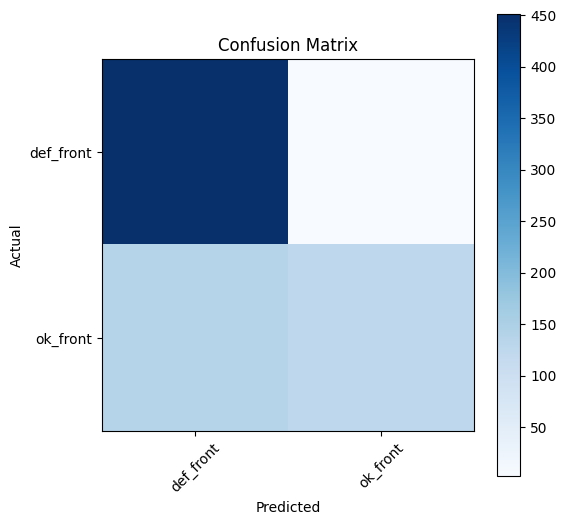

In [ ]:
import os
import timm  # Vision Transformer (ViT) models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ViT
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Update dataset paths for the balanced dataset
train_dataset = datasets.ImageFolder(root=balanced_train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders for balanced dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class indices
print(f"Class Indices: {train_dataset.class_to_idx}")

# Load a pre-trained Vision Transformer (ViT) model
model = timm.create_model('ViT_large_patch16_224', pretrained=True)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2)  # Two output classes (def_front, ok_front)

# Add Dropout to reduce overfitting
model.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% probability
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Hyperparameter tuning: Experiment with different learning rates
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler: Reduce the learning rate when validation loss plateaus
# Learning rate scheduler: Reduce the learning rate when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the scheduler after each epoch
    scheduler.step(running_loss)

    # Print learning rate (using get_last_lr())
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Learning Rate: {current_lr:.6f}")



# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(2), train_dataset.classes, rotation=45)
plt.yticks(range(2), train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Overall Accuracy: {accuracy:.4f}")


Overall Accuracy: 0.8070


In [ ]:
# Save the model
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# Load the model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2)  # Two output classes (def_front, ok_front)
# Load the model with weights_only=True
model.load_state_dict(torch.load('model.pth', weights_only=True))
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
# Function to predict an image
def predict_image(image_path, model):
    # Open the image file
    image = Image.open(image_path)
    # Apply the transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension (unsqueeze)

    # Send the image and model to the appropriate device
    image = image.to(device)
    model = model.to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Get model predictions
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

        # Map class indices back to class names
        predicted_class_name = train_dataset.classes[predicted_class.item()]

    return predicted_class_name

# Example usage
image_path = "/content/drive/MyDrive/The-examples-of-the-open-hole-defect-and-the-casting-fin-defect-The-red-circles-are_Q320.jpg"  # Provide the path to the image you want to predict
predicted_class = predict_image(image_path, model)
print(f"Predicted class: {predicted_class}")


Predicted class: def_front
